# Initialisation GasConsumption and VWAP

In [1075]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import seaborn as sns
from scipy.stats import norm

path='Hedging/HedgeQuarter.xlsx'
xls=pd.ExcelFile(path)
Forward=pd.read_excel(xls,'ForwardPriceMonthly') #Par Mois laisse en mois
VWAP_customers=pd.read_excel(xls,'VWAPCustomers') #Par mois laisse en mois
Consumption_gas=pd.read_excel(xls,'ComsumptionGas2018-2019') #Par Heure passe par mois
#On vas tout convertir par mois car plus simple, pour les heures->jour->mois


#On commence par convertir
def Convert_hourtomonthcons(Consumption_gas):    
    s=0
    Conso_gasmois=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].month!=Consumption_gas['Date'][i].month:
            Conso_gasmois.append(s)
            s=0
    return Conso_gasmois

def Convert_hourtodaycons(Consumption_gas):    
    s=0
    Conso_gasday=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].day!=Consumption_gas['Date'][i].day:
            Conso_gasday.append(s)
            s=0
    return Conso_gasday

ConsomationGasMonth=Convert_hourtomonthcons(Consumption_gas) #Conversion d'heure a mois

Consumption_gas=pd.DataFrame(ConsomationGasMonth,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(ConsomationGasMonth), freq='M'), columns = ['Conso Gas']) # consommation de gas KWH
VWAP_customers=pd.DataFrame(VWAP_customers['VWAP_customers'].values,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(VWAP_customers), freq='M'), columns = ['VWAP_customers'])

# Iniatialisation of gas price over 2016

In [1076]:
dataforward=pd.ExcelFile('ForwardPrice2016.xlsx')
gas=pd.read_excel(dataforward,'Gas')
gas.keys()
gas=gas.drop('Delivery\Today',1)


In [1077]:

gas=pd.DataFrame(gas.values,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys())

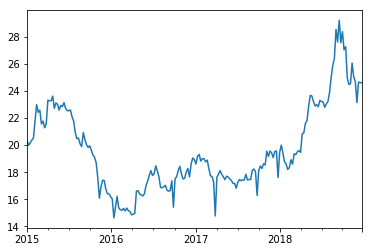

In [1078]:
day=pd.to_datetime('2018-01-31')
gas.loc[pd.to_datetime('2019-01-31')].plot()

## Creation of a Dataframe which do a synthesis of all the Data per month

In [901]:
synthese=VWAP_customers.merge(Consumption_gas,right_index=True,left_index=True)
synthese['Conso Gas']=synthese['Conso Gas']/1000

# Choose of Today Date, for the Forward Price

In [902]:
Today=pd.to_datetime('23-09-2016')
synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
synthese=synthese.rename(columns={Today:'Today'})


# Function calculating the moving Average

In [903]:
def calcul_MM(gas,nbr_week): #MM
    Total=[]
    for i in gas.index:
        mois=[]
        for j in gas.keys():
            s=np.mean(gas.loc[i,j-timedelta(days=nbr_week*7):j])
            mois.append(s)
        Total.append(mois)
    return Total
TotalMM20=calcul_MM(gas,2)
TotalMM50=calcul_MM(gas,9)
MM20=pd.DataFrame(TotalMM20,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys()) #CalculMM20
MM50=pd.DataFrame(TotalMM50,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys()) #CalculMM20

# Vision of the moving average 20 Days, it smooth the curve

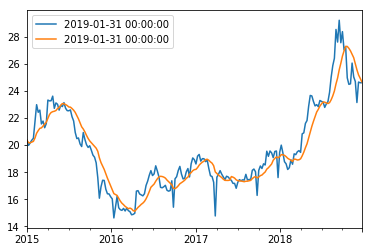

In [904]:
gas.loc[pd.to_datetime('2019-01-31')][:].plot()
MM50.loc[pd.to_datetime('2019-01-31')][:].plot()

plt.legend()

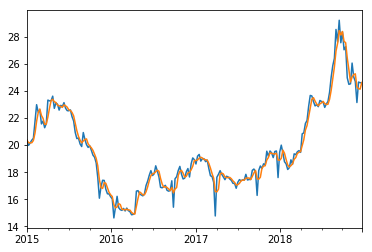

In [1079]:
gas.loc[pd.to_datetime('2019-01-31')].plot()
MM20.loc[pd.to_datetime('2019-01-31')].plot()
#MM50.loc[pd.to_datetime('2019-01-31')].plot()

# Adding the Moving average to the synthesis

In [906]:
synthese=synthese.merge(MM50[Today],left_index=True,right_index=True)
synthese=synthese.rename(columns={Today:'MMToday50'})
synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)

# Defining the Date of the previous Week, and put the moving average in the synthesis

In [907]:
LastWeek=Today-timedelta(days=7)

In [908]:
synthese=synthese.merge(MM50[LastWeek],left_index=True,right_index=True)
synthese=synthese.rename(columns={LastWeek:'MMLastWeek50'})
synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)
synthese

,VWAP_customers,Conso Gas,Today,MMToday50,2016-09-23 00:00:00,MMLastWeek50,2016-09-16 00:00:00
2018-01-31,17.791018,-2313.432807,17.074686,16.971203,16.569187,17.086033,16.376859
2018-02-28,17.792241,-2043.327181,17.007285,16.898002,16.505285,17.011004,16.312524
2018-03-31,17.762505,-1877.761861,16.570338,16.435173,16.068934,16.548954,15.869239
2018-04-30,17.691166,-1341.883546,15.878688,15.702887,15.375273,15.819589,15.163764
2018-05-31,17.626902,-908.000000,15.406689,15.203435,14.899984,15.322956,14.680117
2018-06-30,17.832523,-891.000000,15.278502,15.067867,14.767605,15.189520,14.544910
2018-07-31,17.924734,-895.000000,15.438503,15.236118,14.923564,15.358880,14.702399
2018-08-31,17.935999,-906.000000,15.693948,15.497348,15.179263,15.618883,14.959195
2018-09-30,17.972764,-1067.000000,15.979475,15.781645,15.470326,15.899345,15.249733
2018-10-31,18.123518,-1965.000000,16.323514,16.116680,15.823461,16.228874,15.600857


# Function which gives the signal to Hedge !!!

In [1080]:
def Signal(MarketPrice,VWAP,TodayMM20,LastWeekMM20,TodayMM50,LastWeekMM50,Today):
    Etat=[]
    for i in range(len(VWAP)):
        if (MarketPrice.index[i]-Today).days < 30:
            if MarketPrice[i]>=VWAP[i]+0.5 and TodayMM20[i]>LastWeekMM20[i]+0.40: #the market price above 1 euros avec the mm superiour than last week by 0,15 cents15
                Etat.append('Long')
            elif MarketPrice[i]>=VWAP[i]+0.5 and TodayMM20[i]<LastWeekMM20[i]-0.40:
                Etat.append('Long')

            elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM20[i]>LastWeekMM20[i]+0.40:
                Etat.append('Short')

            elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM20[i]<LastWeekMM20[i]-0.40:
                Etat.append('Short')
            elif MarketPrice[i]>=VWAP[i]-0.5 and MarketPrice[i]<=VWAP[i]+0.5 and abs(TodayMM20[i]-LastWeekMM20[i])>0.5:
                Etat.append('Inbox')
            else :
                Etat.append('Flat')
        else :
            if MarketPrice[i]>=VWAP[i]+0.5 and TodayMM50[i]>=LastWeekMM50[i]+0.50:
                Etat.append('Long')
            elif MarketPrice[i]>=VWAP[i]+0.5 and int(TodayMM50[i])<=LastWeekMM50[i]-0.50:
                Etat.append('Long')
                
            elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM50[i]>=LastWeekMM50[i]+0.50:
                Etat.append('Short')

            elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM50[i]<=LastWeekMM50[i]-0.50:
                Etat.append('Short')
            elif MarketPrice[i]>=VWAP[i]-0.5 and MarketPrice[i]<=VWAP[i]+0.5 and abs(TodayMM50[i]-LastWeekMM50[i])>0.5:
                Etat.append('Inbox')
            else :
                Etat.append('Flat')
            
    return Etat




# Putting the state in the synthesis

In [1081]:
synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek],synthese['MMToday50'],synthese['MMLastWeek50'],Today)

# put the gas consumption in MWH

# Putting the previous hedge to 0

In [1082]:
synthese['PreviousHedge']=0.

# Function for the hedging strategy 

In [1083]:
def Volatility(today,Tdelivery): #en jour
    if ((Tdelivery-today).days/90)<(30/90):
        return (1/5)*(30/90)**(-2/5)
    else:
        return (1/5)*((Tdelivery-today).days/90)**(-2/5)

def delta_vol(ForwardPrice,VWAP,upperPrice):
    Delta=ForwardPrice-VWAP
    if Delta>=upperPrice:
        return 1
    if Delta <=-upperPrice:
        return 0
    else:
        return norm.cdf(Delta,0,upperPrice/3)


def calcul_volume_normal(ForwardPrice,VWAP,upperPrice,BoundVol,VolumeBase,previous_hedge):
    delta=delta_vol(ForwardPrice,VWAP,upperPrice)-0.50
    volume=(BoundVol/0.5)*delta*VolumeBase - previous_hedge
    return volume
    
def coef_aggresivity(volatility,cst_aggresivity): #calcul du coefficient d'agressivity
    return 1.6 -(volatility)-cst_aggresivity


def calcul_upperPrice(today,Tdelivery):  #upperPriceBase,volatility,cst_aggresivity):
    #return upperPriceBase*coef_aggresivity(volatility,cst_aggresivity) #Calcul de l'upperprice
    if ((Tdelivery-today).days)<30:
         return  1.8109*np.log(30)-2.6593 #0.023*(15)-3.59 #(1.67)*np.exp((3/4)*30) #9.7308*np.log(15)-22.079 
    else: 
         return  1.8109*np.log((Tdelivery-today).days)-2.6593 #0.023*((Tdelivery-today).days)-3.59 #9.7308*np.log((Tdelivery-today).days)-23.079 #5.9*((Tdelivery-today).days/30)-3.5 #(1.67)*np.exp((3/4)*(Tdelivery-today).days)

def calcul_volume(BoundPrice,ForwardPrice,VWAP,upperPrice,VolumeBase,previous_hedge,form): #Calcul du volume
        Delta=ForwardPrice-VWAP
        if Delta>upperPrice:
            Delta=upperPrice
        if Delta<-upperPrice:
            Delta=-upperPrice
        if Delta>0:
            if form=='linear':
                return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge #lineaire # Bound price : 0.20 percent
            if form=='quadratic':
                return ((BoundPrice/upperPrice**2)*VolumeBase)*Delta**2 - previous_hedge
            if form=='squared':
                return ((BoundPrice/np.sqrt(upperPrice))*VolumeBase)*np.sqrt(Delta) - previous_hedge
            
        if Delta<0:
            if form=='linear':
                return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge #lineaire # Bound price : 0.20 percent
            if form=='quadratic':
                return -((BoundPrice/upperPrice**2)*VolumeBase)*Delta**2 - previous_hedge
            if form=='squared':
                return -((BoundPrice/np.sqrt(upperPrice))*VolumeBase)*np.sqrt(-Delta) - previous_hedge 



    
def Hedging2(ForwardPrice,VWAP,Volume,Today,Etat,upperPriceBase,cst_agressivity,previousHedge,BoundPrice,form):
    Volume=-Volume
    VolumeHedged=[]
    ValueHedged=[]
    cost_transac=[]
    print(' Hedging Strategy for '+str(Today.day)+'-'+str(Today.month)+'-'+str(Today.year)+' :')
    
    for i in range(len(ForwardPrice)):
        if Etat[i]=='Short':
                #volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice(Today,Etat.index[i]) #upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)   #calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)
                if new_volume>0:
                    new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],'quadratic')
                costtrans=0.1*abs(new_volume)
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        elif Etat[i]=='Long':
                #volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice( Today,Etat.index[i]) #upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],'squared') #calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)
                if new_volume<0:
                    new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],'quadratic')
                costtrans=0.1*abs(new_volume) #long
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))   
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        elif Etat[i]=='Inbox':
                new_volume=-previousHedge[i]
                costtrans=0.1*abs(new_volume) #flt
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros (100)' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                if new_volume>0:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros 100' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))  
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        else:
                VolumeHedged.append(0)
                ValueHedged.append(0)
                cost_transac.append(0)
    return (VolumeHedged,ValueHedged,cost_transac)
    


In [1084]:
ojd=pd.to_datetime('30-09-2016')
deliv=pd.to_datetime('30-09-2021')

Volatility(ojd,deliv)

0.05999660697570666

In [1085]:
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart

Hedg=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.2,'linear')

 Hedging Strategy for 23-9-2016 :


# Vue of synthese

In [1086]:
synthese

,VWAP_customers,Conso Gas,Today,MMToday50,2016-09-23 00:00:00,MMLastWeek50,2016-09-16 00:00:00,Etat,PreviousHedge
2018-01-31,17.791018,-2313.432807,17.074686,16.971203,16.569187,17.086033,16.376859,Flat,0.0
2018-02-28,17.792241,-2043.327181,17.007285,16.898002,16.505285,17.011004,16.312524,Flat,0.0
2018-03-31,17.762505,-1877.761861,16.570338,16.435173,16.068934,16.548954,15.869239,Flat,0.0
2018-04-30,17.691166,-1341.883546,15.878688,15.702887,15.375273,15.819589,15.163764,Flat,0.0
2018-05-31,17.626902,-908.000000,15.406689,15.203435,14.899984,15.322956,14.680117,Flat,0.0
2018-06-30,17.832523,-891.000000,15.278502,15.067867,14.767605,15.189520,14.544910,Flat,0.0
2018-07-31,17.924734,-895.000000,15.438503,15.236118,14.923564,15.358880,14.702399,Flat,0.0
2018-08-31,17.935999,-906.000000,15.693948,15.497348,15.179263,15.618883,14.959195,Flat,0.0
2018-09-30,17.972764,-1067.000000,15.979475,15.781645,15.470326,15.899345,15.249733,Flat,0.0
2018-10-31,18.123518,-1965.000000,16.323514,16.116680,15.823461,16.228874,15.600857,Flat,0.0


# SIMULATION

In [1108]:
synth=pd.DataFrame()
synth=VWAP_customers.merge(Consumption_gas,right_index=True,left_index=True)
synth['Conso Gas']=synthese['Conso Gas']
synth['PreviousHedge']=0.
synth['Valueofhedge']=0.
synth['Cost of transaction']=0.
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart
for Date in gas.keys()[3:20]:
    if 'Today' in synth.columns:
        synth=synth.drop(['Today',Todays,LastWeeks,'MMToday50','MMLastWeek50'],axis=1)
    Todays= Date
    LastWeeks=Todays-timedelta(days=21)
    #ForwardPrice
    synth=synth.merge(gas[Todays],right_index=True,left_index=True)
    synth=synth.rename(columns={Todays:'Today'})
    
    #MM20
    synth=synth.merge(MM50[Todays],left_index=True,right_index=True)
    synth=synth.rename(columns={Todays:'MMToday50'})
    synth=synth.merge(MM20[Todays],left_index=True,right_index=True)
    synth=synth.merge(MM50[LastWeeks],left_index=True,right_index=True)
    synth=synth.rename(columns={LastWeeks:'MMLastWeek50'})
    synth=synth.merge(MM20[LastWeeks],left_index=True,right_index=True)
    #Synth
    #print(synthese)
    #Etat
    synth['Etat']=Signal(synth['Today'],synth['VWAP_customers'],synth[Todays],synth[LastWeeks],synth['MMToday50'],synth['MMLastWeek50'],Todays)
    #Hedging
    Hedgi=Hedging2(synth['Today'],synth['VWAP_customers'],synth['Conso Gas'],Todays,synth['Etat'],upperPriceBase,cst_agressivity,synth['PreviousHedge'],0.2,'squared')
    synth['PreviousHedge']=synth['PreviousHedge']+Hedgi[0]
    synth['Valueofhedge']=synth['Valueofhedge']+Hedgi[1]
    synth['Cost of transaction']=synth['Cost of transaction']+Hedgi[2]
    #Effacement
    

 Hedging Strategy for 23-1-2015 :
 Hedging Strategy for 30-1-2015 :
 Hedging Strategy for 6-2-2015 :
For Delivery in 2019-4 ,Buy 1675.938596 MWH,and we pay is -37106.956444 Euros
For Delivery in 2019-5 ,Buy 1139.201220 MWH,and we pay is -25223.054215 Euros
For Delivery in 2019-6 ,Buy 829.426147 MWH,and we pay is -18364.324314 Euros
For Delivery in 2019-7 ,Buy 878.010554 MWH,and we pay is -19440.031668 Euros
For Delivery in 2019-8 ,Buy 887.891226 MWH,and we pay is -19658.799632 Euros
For Delivery in 2019-9 ,Buy 1083.916658 MWH,and we pay is -23998.998721 Euros
For Delivery in 2019-10 ,Buy 1901.894919 MWH,and we pay is -42109.855396 Euros
For Delivery in 2019-11 ,Buy 2946.269699 MWH,and we pay is -65233.357416 Euros
For Delivery in 2019-12 ,Buy 3825.175031 MWH,and we pay is -84693.200354 Euros
For Delivery in 2020-1 ,Buy 5098.904522 MWH,and we pay is -112894.845022 Euros
For Delivery in 2020-2 ,Buy 4305.248388 MWH,and we pay is -95322.504551 Euros
For Delivery in 2020-3 ,Buy 3665.144228 

 Hedging Strategy for 6-3-2015 :
 Hedging Strategy for 13-3-2015 :
 Hedging Strategy for 20-3-2015 :
 Hedging Strategy for 27-3-2015 :
For Delivery in 2019-4 ,Sold -1879.877674 MWH,and we receive is 41616.731956 Euros
For Delivery in 2019-5 ,Sold -1253.049600 MWH,and we receive is 27740.012052 Euros
For Delivery in 2019-6 ,Sold -908.649471 MWH,and we receive is 20115.681982 Euros
For Delivery in 2019-7 ,Sold -927.110605 MWH,and we receive is 20524.374575 Euros
For Delivery in 2019-8 ,Sold -938.298701 MWH,and we receive is 20772.056637 Euros
For Delivery in 2019-9 ,Sold -1147.983265 MWH,and we receive is 25414.053515 Euros
For Delivery in 2019-10 ,Sold -2065.874584 MWH,and we receive is 45734.331530 Euros
For Delivery in 2019-11 ,Sold -3199.023570 MWH,and we receive is 70819.983799 Euros
For Delivery in 2019-12 ,Sold -4151.289415 MWH,and we receive is 91901.245075 Euros
For Delivery in 2020-1 ,Sold -5176.107952 MWH,and we receive is 114588.677831 Euros
For Delivery in 2020-2 ,Sold -4331

# Test

In [1109]:
synth

,VWAP_customers,Conso Gas,PreviousHedge,Valueofhedge,Cost of transaction,Etat,Today,MMToday50,2015-05-15 00:00:00,MMLastWeek50,2015-04-24 00:00:00
2018-01-31,17.791018,-2313.432807,112.090534,-2983.922989,145.562218,Long,22.632,22.4611,22.615000,22.5678,22.642667
2018-02-28,17.792241,-2043.327181,97.946837,-2610.703428,128.661065,Long,22.632,22.4611,22.615000,22.5678,22.642667
2018-03-31,17.762505,-1877.761861,90.128642,-2401.829376,118.199004,Long,22.632,22.4611,22.615000,22.5678,22.642667
2018-04-30,17.691166,-1341.883546,65.633807,-1745.020244,84.312269,Long,22.632,22.4611,22.615000,22.5678,22.642667
2018-05-31,17.626902,-908.000000,45.111096,-1197.098898,56.957533,Long,22.632,22.4611,22.615000,22.5678,22.642667
2018-06-30,17.832523,-891.000000,40.316058,-1082.138113,56.304713,Long,22.632,22.4611,22.615000,22.5678,22.642667
2018-07-31,17.924734,-895.000000,19.138478,-680.486153,75.834225,Long,21.240,21.2876,21.253000,21.5677,21.215000
2018-08-31,17.935999,-906.000000,19.064202,-681.504347,76.671212,Long,21.240,21.2876,21.253000,21.5677,21.215000
2018-09-30,17.972764,-1067.000000,21.764241,-786.421560,90.101902,Long,21.240,21.2876,21.253000,21.5677,21.215000
2018-10-31,18.123518,-1965.000000,36.149598,-1355.873372,164.750475,Long,21.240,21.2876,21.253000,21.5677,21.215000


# Value given or received

In [1110]:

synth['PreviousHedge'].sum()

16449.605035126588

In [1111]:
synth['Valueofhedge'].sum()

-427347.5426349902

In [1112]:
Value_Portfolio=0
for i in range(len(synth['Valueofhedge'])):
    Value_Portfolio=Value_Portfolio+synth['VWAP_customers'][i]*(-synth['Conso Gas'][i])

In [1113]:
Value_Portfolio

20195175.043586142

In [1114]:
100*(synth['Valueofhedge'].sum()/Value_Portfolio)

-2.1160873412221948

# TEST DU P&L

In [1115]:
PL=pd.DataFrame(index=pd.date_range(start = pd.to_datetime('2018-01-31'),
                             periods = len(synthese), freq='M'))

## Case of volume correlated with price

In [1116]:
PL['VWAP']=synth['VWAP_customers']
PL['Spot Price']=synth['Today'] #RANDOM EST FIXE
PL['Expected Conso']=-synth['Conso Gas'] #consommation en positif
PL['Hedge Volume']=PL['Expected Conso']+synth['PreviousHedge']
PL['Real Conso']=0.

#for i in range(len(PL)):
#    if PL['Spot Price'][i]>PL['VWAP'][i]:
#        PL['Real Conso'][i]=(1+abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][i]
#    else:
#        PL['Real Conso'][i]=(1-abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][i]
PL['Real Conso']=PL['Hedge Volume']
PL['Value Hedge']=synth['Valueofhedge']
PL['Open position Hedge']=(PL['Hedge Volume']-PL['Real Conso'])
PL['Open position Unhedged']=(PL['Expected Conso']-PL['Real Conso'])
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] + PL['Value Hedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP']  - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

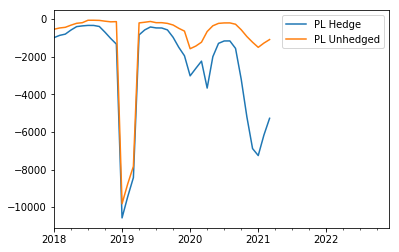

In [1117]:
PL['PL Hedge'].plot()
PL['PL Unhedged'].plot()
plt.legend()


# Simulation of different volume

In [1067]:
simulationhedge=pd.DataFrame(index=PL.index)
simulationunhedge=pd.DataFrame(index=PL.index)
density_hedge=[]
density_unhedge=[]
for i in range(1000):
    for j in range(len(PL)):
        if PL['Spot Price'][j]>PL['VWAP'][j]:
            PL['Real Conso'][j]=np.random.uniform(0.8,1.2)*PL['Expected Conso'][j]
        else:
            PL['Real Conso'][j]=np.random.uniform(0.8,1.2)*PL['Expected Conso'][j]
    simulationhedge['essai n '+str(i)]=PL['Real Conso']*PL['VWAP'] + synth['Valueofhedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
    density_hedge.append(simulationhedge['essai n '+str(i)].sum())
    simulationunhedge['essai n '+str(i)]=PL['Real Conso']*PL['VWAP']  - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']
    density_unhedge.append(simulationunhedge['essai n '+str(i)].sum())

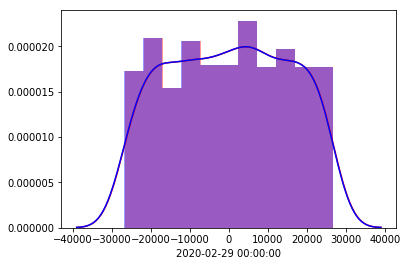

In [1068]:
sns.distplot(simulationhedge.loc[pd.to_datetime('2020-02-29')],color='red')
sns.distplot(simulationunhedge.loc[pd.to_datetime('2020-02-29')],color='blue')

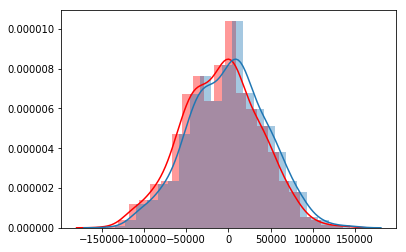

In [1069]:
sns.distplot(density_hedge,color='red')
sns.distplot(density_unhedge)


In [1070]:
comparaison=pd.DataFrame(index=['Mean Hedge','Mean Unhedge','95% Hedge','95% Unhedged','5% Hedge','5% Unhedged'])

In [1071]:
for date in simulationhedge.index:
    MH=simulationhedge.loc[date].mean()
    MU=simulationunhedge.loc[date].mean()
    QH=np.percentile(simulationhedge.loc[date],95,interpolation='linear')
    QU=np.percentile(simulationunhedge.loc[date],95,interpolation='linear')
    QH5=np.percentile(simulationhedge.loc[date],5,interpolation='linear')
    QU5=np.percentile(simulationunhedge.loc[date],5,interpolation='linear')
    comparaison[date]=[MH,MU,QH,QU,QH5,QU5]

In [1072]:
print(comparaison.loc['Mean Hedge'].mean())
print(comparaison.loc['Mean Unhedge'].mean())

-149.05399598188077
-3.4581399984671553


In [1073]:
comparaison.keys()

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

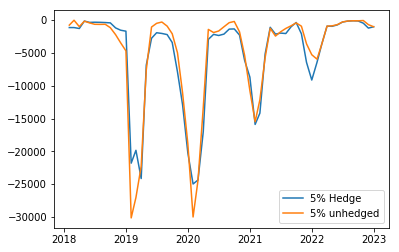

In [1074]:
#plt.plot(comparaison.keys(),comparaison.loc['Mean Hedge'].values,label='Mean Hedge')
#plt.plot(comparaison.keys(),comparaison.loc['Mean Unhedge'].values,label='Mean UnHedge')
#plt.plot(comparaison.keys(),comparaison.loc['95% Hedge'].values,label='95% Hedge')
#plt.plot(comparaison.keys(),comparaison.loc['95% Unhedged'].values,label='95% unhedged')
plt.plot(comparaison.keys(),comparaison.loc['5% Hedge'].values,label='5% Hedge')
plt.plot(comparaison.keys(),comparaison.loc['5% Unhedged'].values,label='5% unhedged')
plt.legend()


## Case Volume not correlated with price

In [896]:
PL['Real Conso']=np.random.normal(1,0.1,len(synthese))*PL['Expected Conso']
PL['Open position']=(PL['Expected Conso']-PL['Real Conso'])
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] +synth['Valueofhedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP'] - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

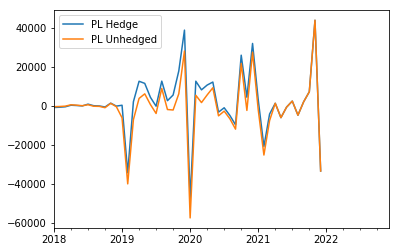

In [303]:
#PL['PL Hedge'].plot()
PL['PL Hedge'].plot()
PL['PL Unhedged'].plot()
plt.legend()

In [304]:
PL.describe()

,VWAP,Spot Price,Expected Conso,Hedge Volume,Real Conso,Value Hedge,Open position Hedge,Open position Unhedged,PL Hedge,PL Unhedged,Open position
count,60.000000,48.000000,60.000000,60.000000,60.000000,60.000000,60.0,60.000000,48.000000,48.000000,60.000000
mean,19.116814,14.365374,17273.111403,15882.579071,17049.420531,22789.478533,0.0,1390.532332,2067.588600,-1022.669182,223.690872
std,0.793508,0.554576,14941.285187,13812.234951,14714.787143,30780.612730,0.0,1885.416934,15675.576330,15570.242581,3204.722488
min,17.626902,13.293876,891.000000,768.350807,838.966556,0.000000,0.0,0.000000,-47930.952711,-57525.432881,-9876.834627
25%,18.619696,13.961459,4025.201856,3603.081413,3886.796887,0.000000,0.0,0.000000,-828.268685,-4216.547835,-616.498399
50%,19.282759,14.316718,11479.756784,10833.679169,11523.256939,3658.367868,0.0,253.460207,509.912538,-317.394301,71.116101
75%,19.497510,14.838621,30062.773067,28024.702373,26531.333616,31431.677773,0.0,1838.592547,7374.480627,2700.502576,559.023080
max,20.475836,15.425628,52672.281273,50944.590164,51092.556565,105705.188336,0.0,6465.102912,43790.343712,43790.343712,12744.227818
